In [145]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [146]:
# Montar o Google Drive (caso esteja usando o Colab)
from google.colab import drive
drive.mount('/content/drive/')

# Definir o caminho dos arquivos no Google Drive
path = "/content/drive/MyDrive/Colab Notebooks/API1S/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [147]:
# Função para carregar todos os dados de exportação para diferentes anos
def carregar_dados():
    anos = ['2019', '2020', '2021', '2022', '2023', '2024']
    dados = {}

    for ano in anos:
        file_path = f"/content/drive/MyDrive/Colab Notebooks/API1S/EXP_{ano}_MUN.csv"
        df_ano = pd.read_csv(file_path, delimiter=';')
        df_ano.columns = df_ano.columns.str.strip()

        # Filtrar para municípios de São Paulo (SP)
        df_sp = df_ano[df_ano['SG_UF_MUN'].str.contains('SP', case=False, na=False)]

        # Armazenar os dados filtrados por ano
        dados[ano] = df_sp

    return dados

In [148]:
# Carregar o arquivo com os códigos e nomes dos municípios
municipios_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/API1S/UF_MUN.csv", delimiter=';', encoding='latin-1')
municipios_df.columns = municipios_df.columns.str.strip()

In [149]:
# Carregar o arquivo NCM_SH.csv (código do produto e nome)
ncm_sh_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/API1S/NCM_SH.csv", delimiter=';', encoding='latin-1')

In [150]:
# Carregar todos os dados de exportação
dados_ano = carregar_dados()

In [151]:
# Filtrar apenas os municípios de São Paulo (SP) com base no conjunto de dados de 2020
municipios_sp = municipios_df[municipios_df['CO_MUN_GEO'].isin(dados_ano['2020']['CO_MUN'].unique())]
municipios_sp_list = sorted(municipios_sp['NO_MUN'].unique().tolist())  # Ordenar a lista de municípios em ordem alfabética

In [152]:
# Função para criar o gráfico interativo e exportar os dados
def criar_grafico_interativo(ano, municipio, carga):
    df_ano = dados_ano[ano].copy()  # Criar uma cópia segura

    # Converter tipos corretamente
    df_ano['CO_MUN'] = df_ano['CO_MUN'].astype(str).copy()
    municipios_df['CO_MUN_GEO'] = municipios_df['CO_MUN_GEO'].astype(str).copy()

    # Mesclar com nomes dos municípios
    df_ano = df_ano.merge(municipios_df[['CO_MUN_GEO', 'NO_MUN']], left_on='CO_MUN', right_on='CO_MUN_GEO', how='left')

    # Mesclar com nomes das cargas e formatar descrição
    df_ano = df_ano.merge(ncm_sh_df[['CO_SH4', 'NO_SH4_POR']], left_on='SH4', right_on='CO_SH4', how='left')
    df_ano['DESCRICAO_SH4'] = df_ano['NO_SH4_POR'].apply(lambda x: (x[:77] + '...') if len(x) > 77 else x) + " (" + df_ano['CO_SH4'].astype(str) + ")"

    # Aplicar filtros
    if municipio != 'Todos':
        df_ano = df_ano[df_ano['NO_MUN'] == municipio]
    if carga != 'Todas':
        df_ano = df_ano[df_ano['NO_SH4_POR'] == carga]

    # Criar coluna de data (mês)
    df_ano['MES'] = pd.to_datetime(df_ano['CO_ANO'] * 100 + df_ano['CO_MES'], format='%Y%m')

    # Mapeamento dos meses para português
    meses_pt = {
        1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
        7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
    }

    # Criar coluna com nome do mês em português
    df_ano['MES_NOME'] = df_ano['MES'].dt.month.map(meses_pt)  # Mapeia o mês para português

    # Calcular o valor agregado (VL_FOB / KG_LIQUIDO), tratando possíveis erros
    df_ano['VALOR_AGREGADO'] = df_ano['VL_FOB'] / df_ano['KG_LIQUIDO']
    df_ano.replace([float('inf'), -float('inf')], 0, inplace=True)  # Substituir infinitos por zero
    df_ano.fillna(0, inplace=True)  # Substituir NaN por zero

    # Agrupar por nome do mês e calcular média do valor agregado
    df_grouped = df_ano.groupby('MES_NOME', as_index=False)['VALOR_AGREGADO'].mean()

    # Ordenar os meses na ordem correta
    meses_ordenados = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]
    df_grouped['MES_NOME'] = pd.Categorical(df_grouped['MES_NOME'], categories=meses_ordenados, ordered=True)
    df_grouped = df_grouped.sort_values('MES_NOME')

    if df_grouped.empty:
        print("Nenhum dado disponível para os filtros selecionados.")
        return

    # Criar gráfico de linhas com o valor agregado médio das exportações ao longo dos meses
    plt.figure(figsize=(12,6))  # Aumentar o tamanho do gráfico para acomodar melhor os rótulos
    plt.plot(df_grouped['MES_NOME'], df_grouped['VALOR_AGREGADO'], marker='o', color='b', label='Valor Agregado')

    # Configurar as grades
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

    # Títulos e rótulos
    plt.title(f'Dados das exportações dos municípios de São Paulo - {ano} ({municipio})')
    plt.xlabel('Mês')
    plt.ylabel('Valor Agregado (R$)')

    # Exibir gráfico
    plt.xticks(rotation=0)  # Exibir os meses de forma horizontal (sem rotação)
    plt.tight_layout()  # Ajustar para que os rótulos não se sobreponham
    plt.show()

    # Exportar os dados filtrados para um arquivo Excel
    output_dir = "/content/drive/MyDrive/Colab Notebooks/API1S/Exportacoes"
    os.makedirs(output_dir, exist_ok=True)  # Criar diretório caso não exista
    output_path = os.path.join(output_dir, f"Exportacoes_{ano}_{municipio.replace(' ', '_')}.xlsx")

    df_grouped.to_excel(output_path, index=False)  # Exportar com nome do mês correto
    print(f"Dados exportados para {output_path}")

In [ ]:
# Criar widgets interativos
ano_dropdown = widgets.Dropdown(
    options=["2019", "2020", "2021", "2022", "2023", "2024"],
    value="2020",
    description='Ano:',
)

municipios_dropdown = widgets.Dropdown(
    options=['Todos'] + municipios_sp_list,  # Adiciona opção "Todos"
    value="Todos",
    description='Município:',
)

carga_dropdown = widgets.Dropdown(
    options=['Todas'] + sorted(ncm_sh_df['NO_SH4_POR'].dropna().unique().tolist()),
    value="Todas",
    description='Carga:',
)

In [ ]:
# Função para atualizar o gráfico dinamicamente
def update_graph(change):
    criar_grafico_interativo(ano_dropdown.value, municipios_dropdown.value, carga_dropdown.value)

In [ ]:
# Associar mudanças nos filtros à função de atualização
ano_dropdown.observe(update_graph, names='value')
municipios_dropdown.observe(update_graph, names='value')
carga_dropdown.observe(update_graph, names='value')

In [ ]:
# Exibir os filtros
display(ano_dropdown, municipios_dropdown, carga_dropdown)

Dropdown(description='Ano:', index=1, options=('2019', '2020', '2021', '2022', '2023', '2024'), value='2020')

Dropdown(description='Município:', options=('Todos', 'ADAMANTINA', 'AGUAI', 'AGUAS DE LINDOIA', 'AGUAS DE SAO …

Dropdown(description='Carga:', options=('Todas', 'Abrasivos naturais ou artificiais, em pó ou em grãos, aplica…

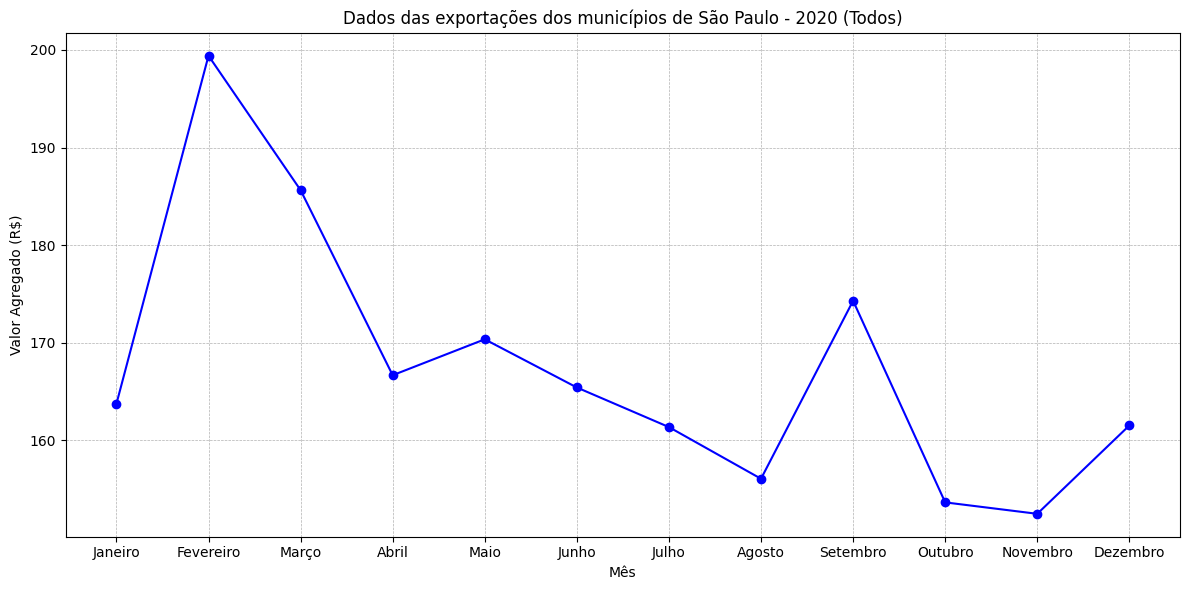

Dados exportados para /content/drive/MyDrive/Colab Notebooks/API1S/Exportacoes/Exportacoes_2020_Todos.xlsx


In [ ]:
# Chamar a função inicial para exibir o gráfico padrão
criar_grafico_interativo("2020", "Todos", "Todas")